## LSTM Measuring

In [212]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Simulation 1: Variogram 0.2

## No scale: Y value 0

In [213]:
# 
training_set = pd.read_csv('datasets/orig_v1_0.csv')
training_set

,x,y,Phi
0,0.0,0.0,0.108549
1,100.0,0.0,0.120677
2,200.0,0.0,0.109326
3,300.0,0.0,0.100903
4,400.0,0.0,0.094381
...,...,...,...
95,9500.0,0.0,0.148605
96,9600.0,0.0,0.031793
97,9700.0,0.0,0.081810
98,9800.0,0.0,0.109246


In [214]:
training_set = training_set.iloc[:,2:3].values
# training_set

In [215]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [216]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, p):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.p = p
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [217]:
num_epochs = 2500
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.40282
Epoch: 100, loss: 0.04149
Epoch: 200, loss: 0.04102
Epoch: 300, loss: 0.04044
Epoch: 400, loss: 0.04023
Epoch: 500, loss: 0.04008
Epoch: 600, loss: 0.03933
Epoch: 700, loss: 0.03566
Epoch: 800, loss: 0.02974
Epoch: 900, loss: 0.02120
Epoch: 1000, loss: 0.01946
Epoch: 1100, loss: 0.01484
Epoch: 1200, loss: 0.01540
Epoch: 1300, loss: 0.01470
Epoch: 1400, loss: 0.01444
Epoch: 1500, loss: 0.01446
Epoch: 1600, loss: 0.01400
Epoch: 1700, loss: 0.01316
Epoch: 1800, loss: 0.01272
Epoch: 1900, loss: 0.01248
Epoch: 2000, loss: 0.01217
Epoch: 2100, loss: 0.01148
Epoch: 2200, loss: 0.01095
Epoch: 2300, loss: 0.01077
Epoch: 2400, loss: 0.01100


Text(0, 0.5, 'Loss')

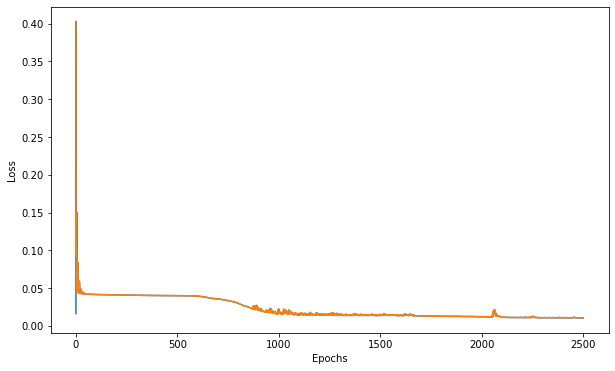

In [218]:
plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

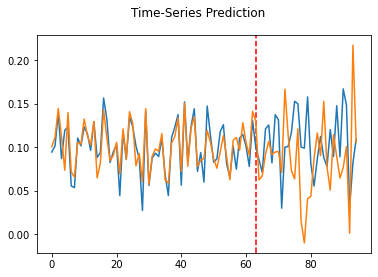

In [219]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [220]:
training_set = pd.read_csv('datasets/orig_v1_100.csv')
training_set

,x,y,Phi
0,0.0,100.0,0.102697
1,100.0,100.0,0.097253
2,200.0,100.0,0.108343
3,300.0,100.0,0.080838
4,400.0,100.0,0.113272
...,...,...,...
95,9500.0,100.0,0.054091
96,9600.0,100.0,0.067456
97,9700.0,100.0,0.110254
98,9800.0,100.0,0.069066


In [221]:
training_set = training_set.iloc[:,2:3].values

In [222]:
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [227]:
num_epochs = 2000
learning_rate = 0.02

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.05292
Epoch: 100, loss: 0.04362
Epoch: 200, loss: 0.04357
Epoch: 300, loss: 0.04338
Epoch: 400, loss: 0.04142
Epoch: 500, loss: 0.03227
Epoch: 600, loss: 0.02833
Epoch: 700, loss: 0.02646
Epoch: 800, loss: 0.02568
Epoch: 900, loss: 0.02462
Epoch: 1000, loss: 0.02350
Epoch: 1100, loss: 0.02252
Epoch: 1200, loss: 0.02165
Epoch: 1300, loss: 0.02105
Epoch: 1400, loss: 0.02056
Epoch: 1500, loss: 0.02002
Epoch: 1600, loss: 0.01959
Epoch: 1700, loss: 0.01920
Epoch: 1800, loss: 0.01891
Epoch: 1900, loss: 0.01867


Text(0, 0.5, 'Loss')

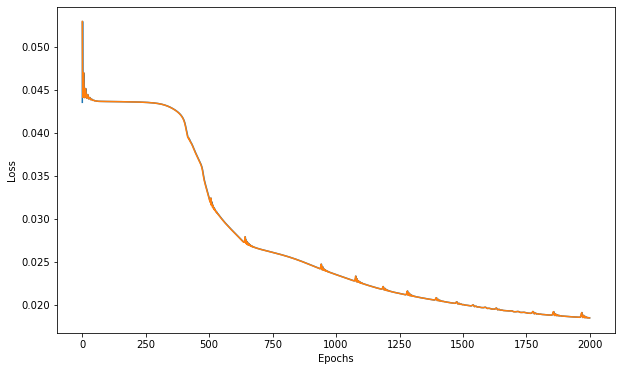

In [228]:
plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

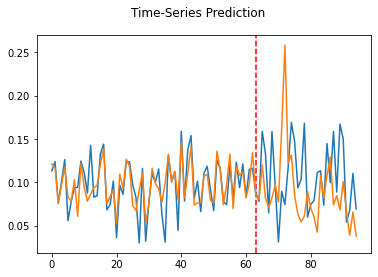

In [229]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [230]:
training_set = pd.read_csv('datasets/orig_v1_1000.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [237]:
num_epochs = 2000 #1000 epochs
learning_rate = 0.07#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.13302
Epoch: 100, loss: 0.01391
Epoch: 200, loss: 0.01390
Epoch: 300, loss: 0.01390
Epoch: 400, loss: 0.01389
Epoch: 500, loss: 0.01387
Epoch: 600, loss: 0.01382
Epoch: 700, loss: 0.01365
Epoch: 800, loss: 0.01328
Epoch: 900, loss: 0.01283
Epoch: 1000, loss: 0.01258
Epoch: 1100, loss: 0.01242
Epoch: 1200, loss: 0.01201
Epoch: 1300, loss: 0.00998
Epoch: 1400, loss: 0.00970
Epoch: 1500, loss: 0.00927
Epoch: 1600, loss: 0.00886
Epoch: 1700, loss: 0.00832
Epoch: 1800, loss: 0.00781
Epoch: 1900, loss: 0.00718


Text(0, 0.5, 'Loss')

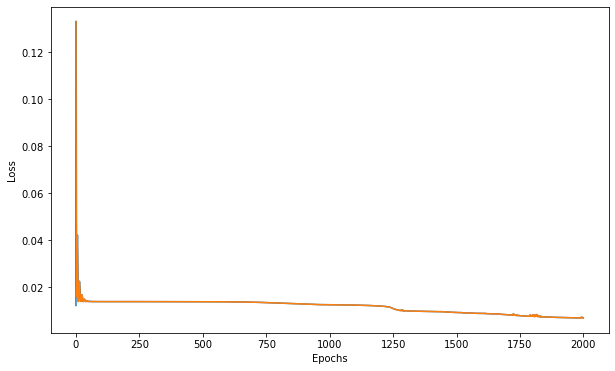

In [238]:
plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

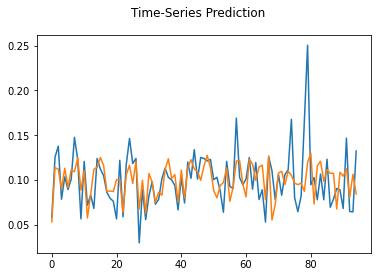

In [239]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [240]:
training_set = pd.read_csv('datasets/orig_v1_5000.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [243]:
num_epochs = 2000 #1000 epochs
learning_rate = 0.06#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.66040
Epoch: 100, loss: 0.05195
Epoch: 200, loss: 0.05166
Epoch: 300, loss: 0.05108
Epoch: 400, loss: 0.05005
Epoch: 500, loss: 0.04928
Epoch: 600, loss: 0.04891
Epoch: 700, loss: 0.04703
Epoch: 800, loss: 0.03876
Epoch: 900, loss: 0.03111
Epoch: 1000, loss: 0.02924
Epoch: 1100, loss: 0.02787
Epoch: 1200, loss: 0.02667
Epoch: 1300, loss: 0.02648
Epoch: 1400, loss: 0.02614
Epoch: 1500, loss: 0.02600
Epoch: 1600, loss: 0.02601
Epoch: 1700, loss: 0.02608
Epoch: 1800, loss: 0.02589
Epoch: 1900, loss: 0.02583


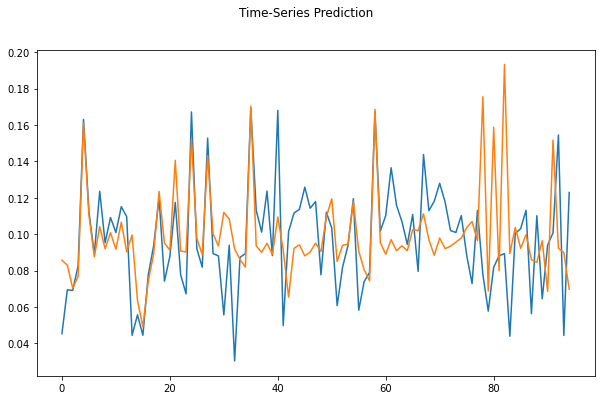

In [244]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [245]:
training_set = pd.read_csv('datasets/orig_v1_9900.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [254]:
num_epochs = 2500 #1000 epochs
learning_rate = 0.08#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.3

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.09760
Epoch: 100, loss: 0.02242
Epoch: 200, loss: 0.02170
Epoch: 300, loss: 0.02101
Epoch: 400, loss: 0.02038
Epoch: 500, loss: 0.01830
Epoch: 600, loss: 0.01466
Epoch: 700, loss: 0.01462
Epoch: 800, loss: 0.00949
Epoch: 900, loss: 0.00919
Epoch: 1000, loss: 0.00826
Epoch: 1100, loss: 0.00819
Epoch: 1200, loss: 0.00794
Epoch: 1300, loss: 0.00734
Epoch: 1400, loss: 0.00716
Epoch: 1500, loss: 0.00693
Epoch: 1600, loss: 0.00712
Epoch: 1700, loss: 0.00679
Epoch: 1800, loss: 0.00676
Epoch: 1900, loss: 0.00684
Epoch: 2000, loss: 0.00664
Epoch: 2100, loss: 0.00662
Epoch: 2200, loss: 0.00667
Epoch: 2300, loss: 0.00661
Epoch: 2400, loss: 0.00645


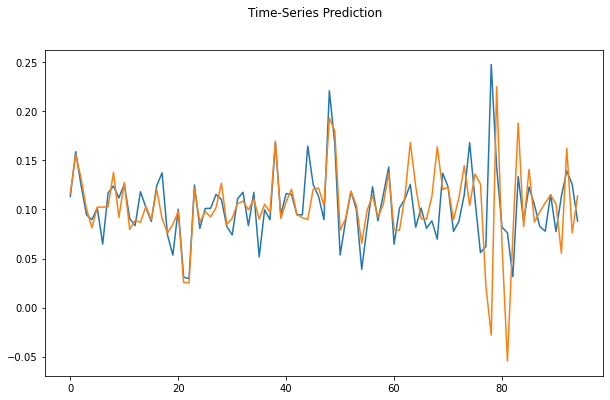

In [255]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## Variogram 0.2, Scaled by 50

In [257]:
training_set = pd.read_csv('datasets/scaled_v1_50_100.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [260]:
num_epochs = 2000 #1000 epochs
learning_rate = 0.03#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.3

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.08542
Epoch: 100, loss: 0.03521
Epoch: 200, loss: 0.03436
Epoch: 300, loss: 0.02699
Epoch: 400, loss: 0.02367
Epoch: 500, loss: 0.01706
Epoch: 600, loss: 0.01110
Epoch: 700, loss: 0.01028
Epoch: 800, loss: 0.00988
Epoch: 900, loss: 0.00963
Epoch: 1000, loss: 0.00934
Epoch: 1100, loss: 0.00922
Epoch: 1200, loss: 0.00893
Epoch: 1300, loss: 0.00848
Epoch: 1400, loss: 0.00840
Epoch: 1500, loss: 0.00826
Epoch: 1600, loss: 0.00961
Epoch: 1700, loss: 0.00816
Epoch: 1800, loss: 0.00739
Epoch: 1900, loss: 0.00702


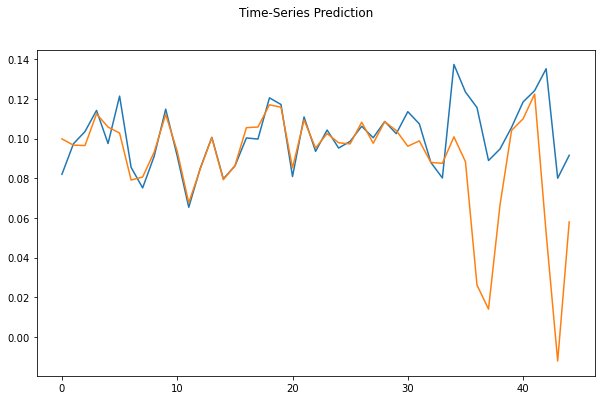

In [261]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [264]:
training_set = pd.read_csv('datasets/scaled_v1_50_115.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [265]:
num_epochs = 2000 #1000 epochs
learning_rate = 0.03#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.3

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.36585
Epoch: 100, loss: 0.03419
Epoch: 200, loss: 0.03407
Epoch: 300, loss: 0.03369
Epoch: 400, loss: 0.03334
Epoch: 500, loss: 0.03300
Epoch: 600, loss: 0.03126
Epoch: 700, loss: 0.02310
Epoch: 800, loss: 0.01714
Epoch: 900, loss: 0.01003
Epoch: 1000, loss: 0.00676
Epoch: 1100, loss: 0.00476
Epoch: 1200, loss: 0.00366
Epoch: 1300, loss: 0.00303
Epoch: 1400, loss: 0.00270
Epoch: 1500, loss: 0.00242
Epoch: 1600, loss: 0.00230
Epoch: 1700, loss: 0.00213
Epoch: 1800, loss: 0.00199
Epoch: 1900, loss: 0.00223


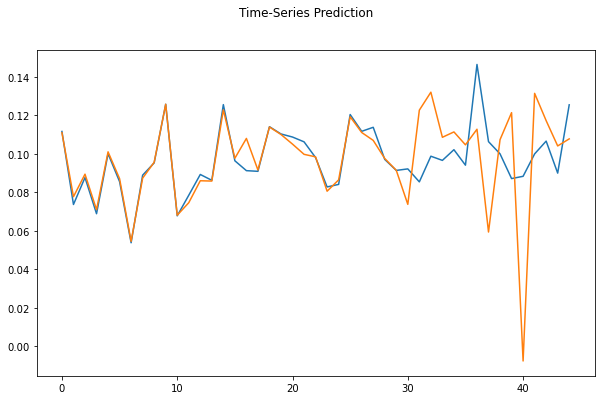

In [266]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [267]:
training_set = pd.read_csv('datasets/scaled_v1_50_515.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [268]:
num_epochs = 2000 #1000 epochs
learning_rate = 0.03#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.3

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.19755
Epoch: 100, loss: 0.06013
Epoch: 200, loss: 0.05935
Epoch: 300, loss: 0.05200
Epoch: 400, loss: 0.03758
Epoch: 500, loss: 0.03138
Epoch: 600, loss: 0.02846
Epoch: 700, loss: 0.02563
Epoch: 800, loss: 0.02285
Epoch: 900, loss: 0.02063
Epoch: 1000, loss: 0.01893
Epoch: 1100, loss: 0.01716
Epoch: 1200, loss: 0.01627
Epoch: 1300, loss: 0.01586
Epoch: 1400, loss: 0.01563
Epoch: 1500, loss: 0.01546
Epoch: 1600, loss: 0.01532
Epoch: 1700, loss: 0.01520
Epoch: 1800, loss: 0.01510
Epoch: 1900, loss: 0.01498


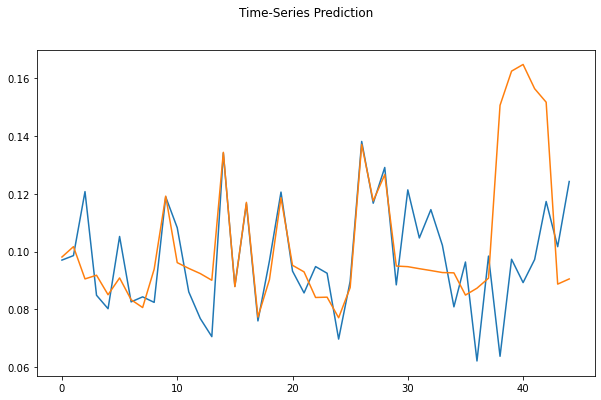

In [269]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
training_set = pd.read_csv('datasets/scaled_v1_50_115.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))